In [1]:
import os
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from setting.setting import *

In [2]:
data_dir = "../../dataset/processed/v1/training"
val_data_dir = "../../dataset/processed/v1/validation"
model_dir = "../../models/CNN"
best_model_filename = "cnn_best_model_v1.keras"

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
).map(lambda x, y: (x / 255.0, y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
).map(lambda x, y: (x / 255.0, y))

Found 21945 files belonging to 26 classes.
Found 2465 files belonging to 26 classes.


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1),
])

In [5]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [6]:
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=L2(0.001)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

In [7]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=1
)

checkpoint = ModelCheckpoint(
    os.path.join(model_dir, best_model_filename),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [9]:
final_total_epochs = 1000
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=final_total_epochs,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/1000
686/686 [==============================] - ETA: 0s - loss: 1.7312 - accuracy: 0.4903
Epoch 1: val_accuracy improved from -inf to 0.88316, saving model to ../../models/CNN\cnn_best_model_v1.keras
686/686 [==============================] - 191s 219ms/step - loss: 1.7312 - accuracy: 0.4903 - val_loss: 0.5048 - val_accuracy: 0.8832
Epoch 2/1000
686/686 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.7641
Epoch 2: val_accuracy improved from 0.88316 to 0.91846, saving model to ../../models/CNN\cnn_best_model_v1.keras
686/686 [==============================] - 78s 112ms/step - loss: 0.8436 - accuracy: 0.7641 - val_loss: 0.3468 - val_accuracy: 0.9185
Epoch 3/1000
685/686 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.8246
Epoch 3: val_accuracy improved from 0.91846 to 0.93955, saving model to ../../models/CNN\cnn_best_model_v1.keras
686/686 [==============================] - 65s 94ms/step - loss: 0.6472 - accuracy: 0.8247 - val_loss

In [10]:
print(f"Mô hình tốt nhất đã được lưu tại: {os.path.join(model_dir, best_model_filename)}")

Mô hình tốt nhất đã được lưu tại: ../../models/CNN\cnn_best_model_v1.keras


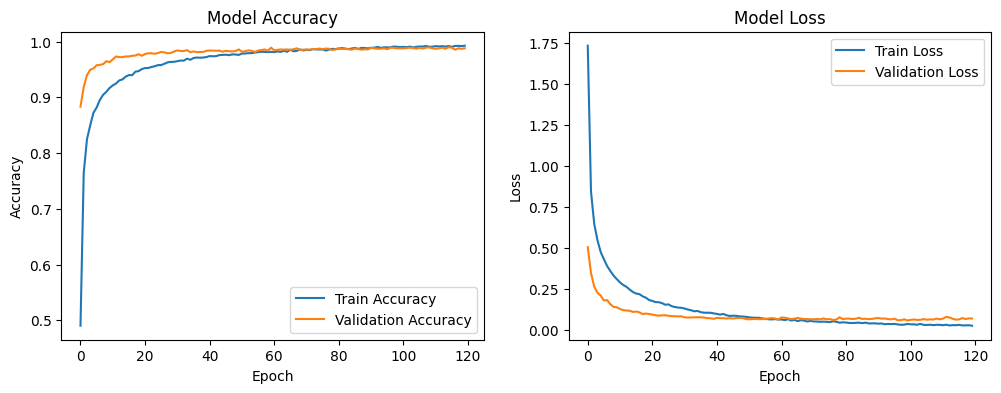

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 158ms/step


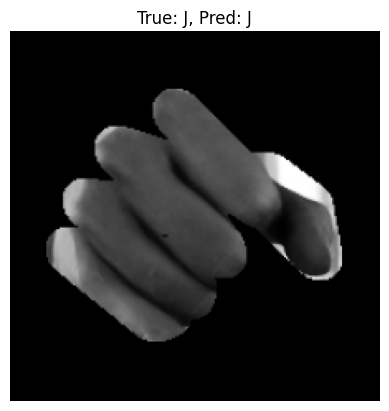

In [12]:
import random
import numpy as np
import string

val_images, val_labels = next(iter(val_ds))
random_index = random.randint(0, BATCH_SIZE - 1)
img = val_images[random_index]
true_label = val_labels[random_index]

pred = model.predict(tf.expand_dims(img, axis=0))
pred_label = string.ascii_uppercase[np.argmax(pred)]
true_label_str = string.ascii_uppercase[np.argmax(true_label)]

plt.imshow(img)
plt.title(f"True: {true_label_str}, Pred: {pred_label}")
plt.axis('off')
plt.show()